In [329]:
"""Mkt APIs"""
from fredapi import Fred
import numpy as np
import pandas as pd
import yfinance as yf
import yahooquery as yq
from fredapi import Fred
import datetime as dt
from scipy import optimize
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca.trading.client import TradingClient
import matplotlib.pyplot as plt

KEY = "PKQ9XJDJLTX686HE3ZL9"
SECRET = "4ES985YvYlOWz0eAtzdhcETJ1asEPBSw3gq9ZXs7"
ENDP = "https://paper-api.alpaca.markets"
API = TradingClient(KEY, SECRET)
STOCK_LIST = ["AAPL", "TSLA", "AMZN", "GOOG", "BA", "NKE", "AMGN", "KO", "PG", "MSFT", "CRM", "JPM"]
FRED = Fred(api_key="f3fea224d98377beff02b72fbe0cb196")
RRF = (FRED.get_series_latest_release("GS10")/12).iloc[-1]

In [297]:
"""ML libs"""
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp

In [298]:
def get_data(stocks, start_date, end_date):
    stock_data = yf.download(stocks, start_date, end_date)
    stock_data = pd.DataFrame(stock_data)
    closing_prices = stock_data["Close"]
    returns = closing_prices.pct_change()[1:]
    log_returns = np.log(returns+1)[1:]
    #print(log_returns)
    #mean_of_returns = log_returns.mean()
    #cov_of_returns = log_returns.cov()


    return {"returns":returns, "log_returns":log_returns}# , mean_of_returns, cov_of_returns

In [299]:
"""Data retrieval test"""
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=400)

data = get_data(["BA"], start_date, end_date)
log_returns_pd = data["log_returns"]
returns_pd = data["returns"]
log_returns = np.array(log_returns_pd)#log_returns_pd.iloc[1]
returns = np.array(returns_pd)
#print(log_returns)
#print(np.array(log_returns_pd))

[*********************100%%**********************]  1 of 1 completed


In [309]:
"""Build regressor"""
#data, i=0, ma=3, ar=7
def build_regressor(data, i=0, ma=0, ar=30):
    regressor = tfp.sts.AutoregressiveIntegratedMovingAverage(observed_time_series=data, ar_order=ar, ma_order=ma, integration_degree=i)
    variational_posts = tfp.sts.build_factored_surrogate_posterior(model=regressor)
    # Allow external control of optimization to reduce test runtimes.
    num_variational_steps = 200 # @param { isTemplate: true}
    num_variational_steps = int(num_variational_steps)

    # Build and optimize the variational loss function.
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=regressor.joint_distribution(
            observed_time_series=data).log_prob,
        surrogate_posterior=variational_posts,
        optimizer=tf.optimizers.Adam(learning_rate=0.1),
        num_steps=num_variational_steps,
        jit_compile=True)

    return {"regressor":regressor, "variational_posteriors":variational_posts}


In [301]:
"""Sample run"""
log_model = build_regressor(log_returns)
raw_model = build_regressor(returns)
log_regressor = log_model["regressor"]
raw_regressor = raw_model["regressor"]
log_post = log_model["variational_posteriors"]
raw_post = raw_model["variational_posteriors"]



In [305]:
#print(log_regressor.ar_coefficients)
#print(q_samples_fuck_(log_regressor.parameters[0].name))
#print(log_regressor.parameters[0])
#print(log_regressor.get_parameter('ar_coefficients'))

def get_coeffs(n_samps, log_post=log_post):
    samples = log_post.sample(n_samps)
    coeffs = samples['ar_coefficients']
    coeff_means = np.mean(coeffs, axis=0)
    coeff_vars = np.var(coeffs, axis=0)

    return {"coeffs":coeffs, "coeff_means":coeff_means, "coeff_vars":coeff_vars}
    #print(samples)

In [303]:
"""TIME metric"""
results = get_coeffs(50)
mean_coeffs = results['coeff_means']
vars = results['coeff_vars']
TIME = abs(np.sum(mean_coeffs)/(1-np.sum(mean_coeffs)))
MIM_no_norm = np.sum(np.abs(mean_coeffs))/(1+(np.sum(np.abs(mean_coeffs))))
print(mean_coeffs)
print("TIME: ", TIME)
print("MIM (no norm): ", MIM_no_norm)
print(vars)


[-0.03569032 -0.01339337 -0.07525522 -0.02671612  0.07680117 -0.01444454
  0.05468182 -0.01131654  0.07728874  0.04811299  0.06492027  0.01023161
  0.04422125  0.02256129  0.05899598 -0.05496413  0.03904998 -0.00894182
 -0.02422117 -0.00772497  0.0377469   0.00913858 -0.02433025 -0.05874642
 -0.0591302  -0.03988716 -0.0272289   0.0444319  -0.06666679 -0.08350266]
TIME:  0.04212548808775724
MIM (no norm):  0.5496191441473656
[0.00044967 0.00044793 0.00031698 0.00050894 0.00040853 0.00108777
 0.00020367 0.00022765 0.00023662 0.00035654 0.00138228 0.00047323
 0.00098702 0.00070487 0.00024729 0.00036291 0.00068765 0.00039389
 0.00249703 0.00153436 0.00027009 0.0009423  0.00055986 0.00042188
 0.00051439 0.0004807  0.00013123 0.00139873 0.00131369 0.00196377]


In [325]:
"""Looper"""
ar = 7
data_size = 20
sample_size = 10000
amims = []
i = 0
#for i in range(len(log_returns)-data_size):
while (i < len(log_returns)-data_size):
    data = log_returns[i:i+data_size]
    log_model = build_regressor(data)
    log_posts = log_model["variational_posteriors"]
    regressor = log_model["regressor"]
    coeff_data = get_coeffs(sample_size, log_post=log_posts)['coeffs']
    coeff_samps = coeff_data['coeffs']
    coeff_means = coeff_data['coeff_means']
    coeff_vars = coeff_data['coeff_vars']
    print(coeff_samps.shape)
    mims = np.sum(np.abs(coeff_samps), axis=1)/(1+(np.sum(np.abs(coeff_samps), axis=1)))
    print(mims.shape)
    quant = np.quantile(mims, 0.95, method='normal_unbiased')
    amim = (np.mean(mims)-quant)/(1-quant)
    amims.append(amim)
    i += data_size




(10000,)


(10000,)


(10000,)


(10000,)


(10000,)


(10000,)


(10000,)


(10000,)


(10000,)


(10000,)


(10000,)


(10000,)


(10000,)


[-0.16930324519628287, -0.17185347589754904, -0.17750112223374068, -0.1764965101759034, -0.17295889548016236, -0.1828200757434882, -0.17614436202079184, -0.17570706857864643, -0.1727072082121276, -0.1759157513989064, -0.1745596828717624, -0.17771373938315546, -0.1808736419629264]


ValueError: x and y must have same first dimension, but have shapes (14,) and (13,)

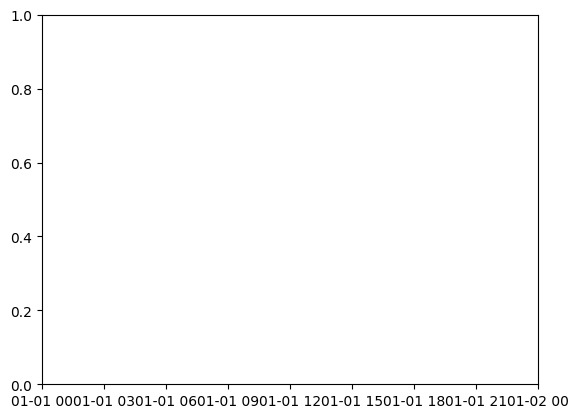

In [344]:
log_returns_pd.index.to_list()[0:data_size:]
print(amims)
plt.plot(log_returns_pd.index.to_list()[0::data_size+1], amims)
log_returns_pd.index.to_list()
